# Importações e Verificação da GPU

In [1]:
import os
import io
import time
import torch
import random
import numpy as np
import pandas as pd
import pickle
import urllib.request
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from collections import Counter
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, ResNet18_Weights, resnet152, ResNet152_Weights
import warnings
warnings.filterwarnings('ignore')

In [2]:
if torch.cuda.is_available():
    print(f'Number of GPUs: {torch.cuda.device_count()}')
    print(f'Model GPU: {torch.cuda.get_device_name(0)}')
    print(f'Total GPU Memory [GB]: {torch.cuda.get_device_properties(0).total_memory / 1e9}')
else:
    print('GPU not available')

Number of GPUs: 1
Model GPU: NVIDIA GeForce RTX 3060
Total GPU Memory [GB]: 12.623478784


# Carregando o Conjunto de Dados de Imagens

In [3]:
data_dir = Path('dados/dados/')

In [4]:
transformador = T.Compose([T.Resize((256, 256)), T.ToTensor()])

In [5]:
dataset = ImageFolder(data_dir, transform= transformador)

In [6]:
type(dataset)

torchvision.datasets.folder.ImageFolder

In [7]:
print(dataset.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [8]:
labels = [item[1] for item in dataset.imgs]
classes = dataset.classes

image_count_per_class = Counter(labels)

image_count_per_folder = {classes[idx]: count for idx, count in image_count_per_class.items()}

image_counts = [count for count in image_count_per_class.values()]

for folder, count in image_count_per_folder.items():
    print(f'Folder --> {folder}, Number of Images: {count}')

Folder --> cardboard, Number of Images: 403
Folder --> glass, Number of Images: 501
Folder --> metal, Number of Images: 410
Folder --> paper, Number of Images: 594
Folder --> plastic, Number of Images: 482
Folder --> trash, Number of Images: 137


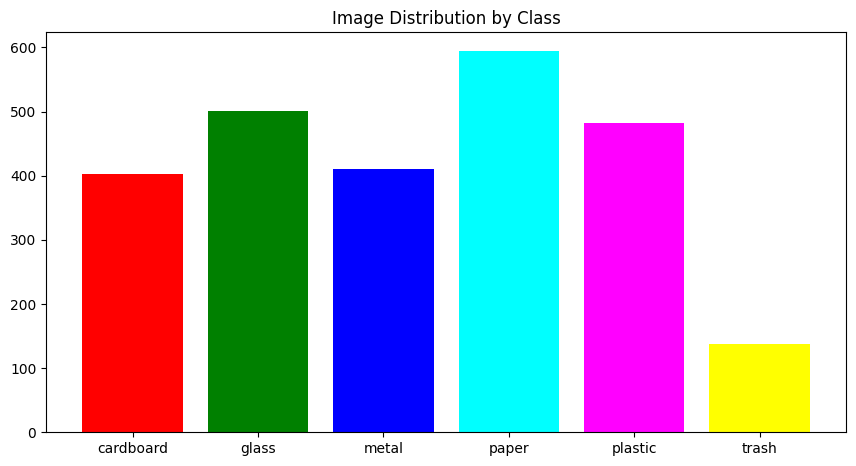

In [9]:
fig = plt.figure(figsize=(8, 4))

ax = fig.add_axes([0, 0, 1, 1])

counts = image_counts
colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow']
ax.bar(dataset.classes, counts, color = colors)

plt.title('Image Distribution by Class')
plt.show()

# Preparação das Imagens

In [10]:
def split(length) -> tuple:
    r = .05
    test_val = int(round(length * r, 0))
    train = int(round(length - test_val * 2, 0))
    return (train, test_val, test_val)

In [11]:
data_train, data_test, data_valid = random_split(dataset, split(len(dataset)), generator= torch.Generator().manual_seed(42))

In [12]:
print(f'Splits: {(len(data_train), len(data_test), len(data_valid))}')

Splits: (2275, 126, 126)


In [13]:
batch_size = 16

In [14]:
dl_train = DataLoader(dataset= data_train,
                      batch_size= batch_size,
                      shuffle= True,
                      num_workers= 4,
                      pin_memory= True)

In [15]:
dl_test = DataLoader(dataset= data_test,
                     batch_size= batch_size,
                     num_workers= 4,
                     pin_memory= True)

In [16]:
dl_valid = DataLoader(dataset= data_valid,
                      batch_size= batch_size,
                      num_workers= 4,
                      pin_memory= True)

# Transferindo os Data Loaders Para o Dispositivo (CPU ou GPU)

In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [18]:
print(device)

cuda


In [19]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

In [20]:
class DeviceDataLoader():

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

    def __len__(self):
        return len(self.dl)

In [21]:
dl_train = DeviceDataLoader(dl_train, device)
dl_test = DeviceDataLoader(dl_test, device)
dl_valid = DeviceDataLoader(dl_valid, device)

# Visualizando as Imagens

In [22]:
def view_batch(dl):

    fig, ax = plt.subplots(figsize = (15, 10))

    for images, laabels in dl:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images.cpu(), nrow = batch_size // 2).permute(1, 2, 0))
        break

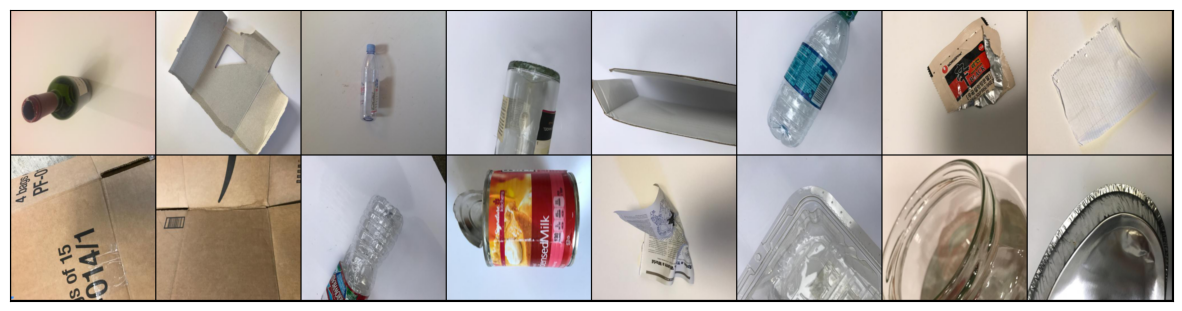

In [23]:
view_batch(dl_train)

# Construção do Modelo

## Definindo o Modelo Base

In [24]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [25]:
class ImageClassificationBase(nn.Module):

    def __init__(self):
        super().__init__()
        self.history = None
        self.maxAcc = None
        self.evalAcc = None

    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(f'Epoch {epoch+1}: train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}')

In [26]:
class ResNet18(ImageClassificationBase):

    def __init__(self):

        super().__init__()
        self.network = resnet18(weights= ResNet18_Weights.IMAGENET1K_V1)
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
        self.name = 'ResNet18'

    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [27]:
class ResNet152(ImageClassificationBase):

    def __init__(self):

        super().__init__()
        self.network = resnet152(weights= ResNet152_Weights.IMAGENET1K_V1)
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
        self.name = 'ResNet152'

    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [28]:
models = [ResNet18(), ResNet152()]

In [29]:
models_name = [model.name for model in models]

In [30]:
models_name

['ResNet18', 'ResNet152']

# Loop de Treinamento e Avaliação

In [31]:
@torch.no_grad()
def evaluate(model, val_loader):

    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [32]:
def fit(epochs, model, train_loader, val_loader, optimizer):

    history = []

    for epoch in range(epochs):
        model.train()
        train_losses = []

        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [33]:
def find_better_model(models):

    best_model = None
    best_score = -float('inf')

    for model in models:
        score = model.maxAcc + model.evalAcc

        if score > best_score:
            best_score = score
            best_model = model

    return best_model

In [34]:
def search_better_model(epochs, lr, models, train_loader, val_loader):

    result_models = []
    safety_sleep = 15

    for model in models:
        print(f'\nStarting model training: {model.name}')
        model = to_device(model, device)
        optimizer = torch.optim.Adam(model.parameters(), lr = lr)
        history = fit(epochs, model, train_loader, val_loader, optimizer)
        model.history = pd.DataFrame(history, columns= ['train_loss', 'val_loss', 'val_acc'])
        model.maxAcc = max([x['val_acc'] for x in history])
        model.evalAcc = evaluate(model, dl_test)['val_acc']
        result_models.append(model)

        if model.name != models_name[-1]:
            print(f'\nResting for {safety_sleep} seconds')
            time.sleep(safety_sleep)
            safety_sleep += 5

    best_model = find_better_model(result_models)
    print('\nTraining Completed')

    return best_model, result_models

In [35]:
num_epochs = 5
learning_rate = 5.5e-5

In [36]:
%%time
best_model, result = search_better_model(num_epochs,
                                         learning_rate,
                                         models,
                                         dl_train,
                                         dl_valid)


Starting model training: ResNet18
Epoch 1: train_loss: 1.4007, val_loss: 1.2345, val_acc: 0.8817
Epoch 2: train_loss: 1.1879, val_loss: 1.1759, val_acc: 0.8962
Epoch 3: train_loss: 1.1213, val_loss: 1.1427, val_acc: 0.9219
Epoch 4: train_loss: 1.0943, val_loss: 1.1330, val_acc: 0.9286
Epoch 5: train_loss: 1.0765, val_loss: 1.1248, val_acc: 0.9286

Resting for 15 seconds

Starting model training: ResNet152
Epoch 1: train_loss: 1.3263, val_loss: 1.1509, val_acc: 0.8973
Epoch 2: train_loss: 1.1347, val_loss: 1.1297, val_acc: 0.9208
Epoch 3: train_loss: 1.0984, val_loss: 1.1203, val_acc: 0.9040
Epoch 4: train_loss: 1.0918, val_loss: 1.1084, val_acc: 0.9208
Epoch 5: train_loss: 1.0775, val_loss: 1.0993, val_acc: 0.9453

Training Completed
CPU times: user 1min 42s, sys: 2min 17s, total: 3min 59s
Wall time: 4min 8s


# Salvando os Modelos

In [37]:
name_models = [model.name for model in result]

In [38]:
folder_models = Path('modelos/')

In [39]:
for i in range(len(name_models)):
    file = open(os.path.join(folder_models, f'{name_models[i]}.pkl'), 'wb')
    pickle.dump(result[i], file)
    file.close()

# Carregando os Modelos para Teste e Deploy

In [40]:
class DeviceUnpickler(pickle.Unpickler):

    def find_class(self, module, name):

        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location = device)
        else:
            return super().find_class(module, name)

In [41]:
loaded_models = []

for i in range(len(name_models)):
    file = open(os.path.join(folder_models, f'{name_models[i]}.pkl'), 'rb')
    loaded_models.append(DeviceUnpickler(file).load())
    file.close()

In [42]:
best_model = find_better_model(loaded_models)

In [43]:
best_model.name

'ResNet152'

# Avaliação e Seleção

In [44]:
def plot_acc(history):
    accuracies = [acc for acc in history['val_acc']]
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy x Number of Epochs')

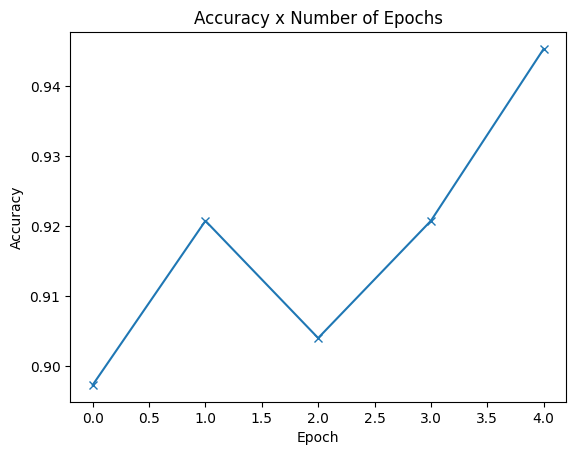

In [45]:
plot_acc(best_model.history)

In [46]:
def plot_erro(history):
    train_losses = [x for x in history['train_loss']]
    val_losses = [x for x in history['val_loss']]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('Epoch')
    plt.ylabel('Erro')
    plt.legend(['Training', 'Validation'])
    plt.title('Erro x Number of Epochs')

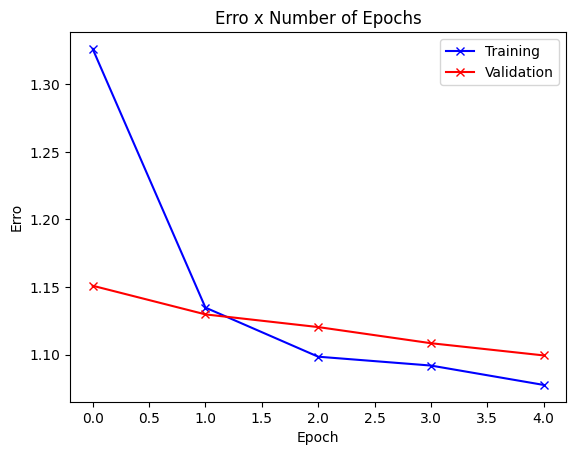

In [47]:
plot_erro(best_model.history)

In [48]:
maxAcc = [model.maxAcc for model in loaded_models]
evalAcc = [model.evalAcc for model in loaded_models]

In [49]:
acc_df = pd.DataFrame(zip(maxAcc, evalAcc), columns= ['maxAcc', 'evalAcc'], index= name_models)
acc_df['model_score'] = acc_df['maxAcc'] + acc_df['evalAcc']
acc_df

,maxAcc,evalAcc,model_score
ResNet18,0.928571,0.936384,1.864955
ResNet152,0.945312,0.928571,1.873884


# Previsões com Dados de Teste

In [50]:
def image_predict(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    prob, preds = torch.max(yb, dim = 1)
    return dataset.classes[preds[0].item()]

label: paper, Prediction: paper


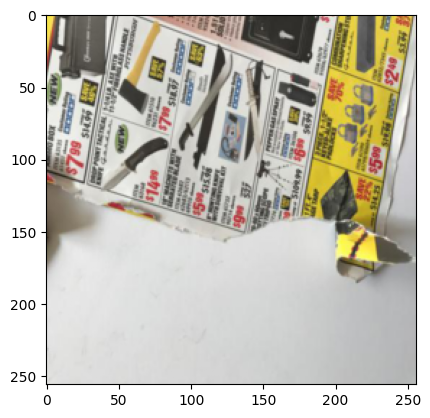

In [58]:
img, label = data_test[52]
plt.imshow(img.permute(1, 2, 0))
print(f'label: {dataset.classes[label]}, Prediction: {image_predict(img, best_model)}')

Label: metal, Prediction: metal


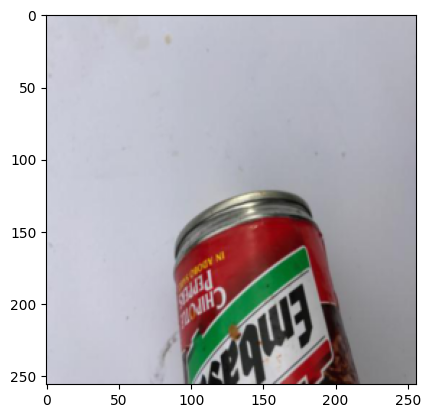

In [59]:
img, label = data_test[34]
plt.imshow(img.permute(1, 2, 0))
print(f'Label: {dataset.classes[label]}, Prediction: {image_predict(img, best_model)}')

Label: paper, Prediction: paper


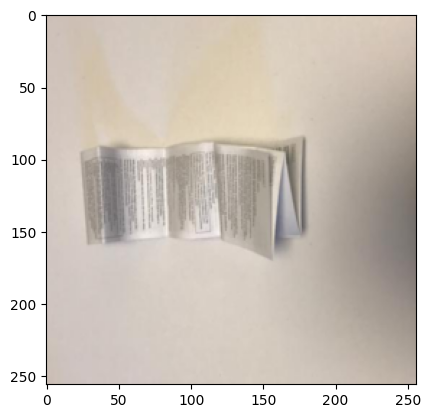

In [60]:
img, label = data_test[19]
plt.imshow(img.permute(1, 2, 0))
print(f'Label: {dataset.classes[label]}, Prediction: {image_predict(img, best_model)}')

# Deploy e Uso do Modelo em Novas Imagens

In [56]:
img_dir = Path('novos_dados/')

In [57]:
image1 = os.path.join(img_dir, 'imagem1.jpg')
image2 = os.path.join(img_dir, 'imagem2.jpg')
image3 = os.path.join(img_dir, 'imagem3.jpg')
image4 = os.path.join(img_dir, 'imagem4.jpg')
image5 = os.path.join(img_dir, 'imagem5.jpg')
image6 = os.path.join(img_dir, 'imagem6.jpg')

In [61]:
def classify_image(img_path):

    image = Image.open(img_path)
    example_image = transformador(image)

    plt.imshow(example_image.permute(1, 2, 0))
    print(f'Prediction for the image: {image_predict(example_image, best_model)}.')

Prediction for the image: cardboard.


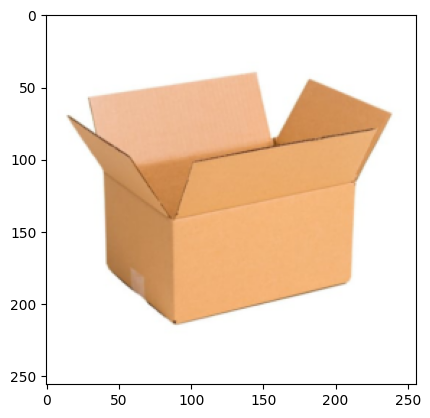

In [62]:
classify_image(image1)

Prediction for the image: glass.


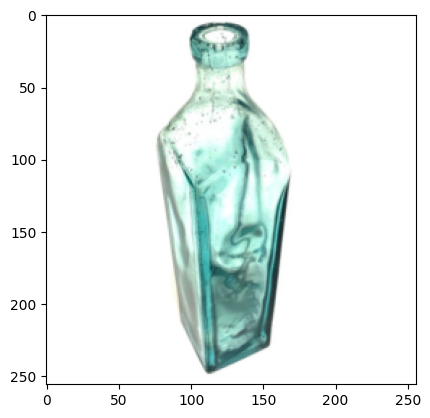

In [63]:
classify_image(image2)

Prediction for the image: metal.


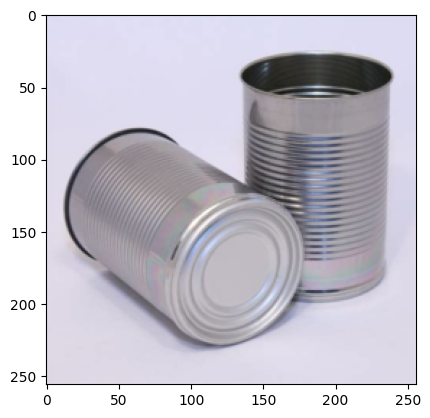

In [64]:
classify_image(image3)

Prediction for the image: paper.


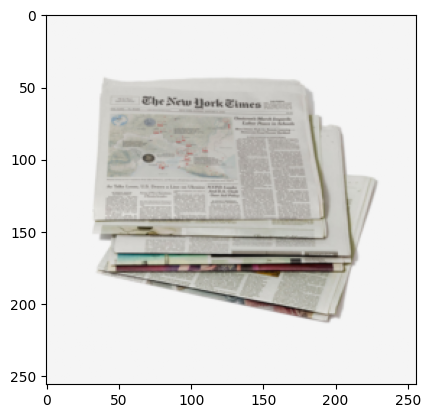

In [65]:
classify_image(image4)

Prediction for the image: paper.


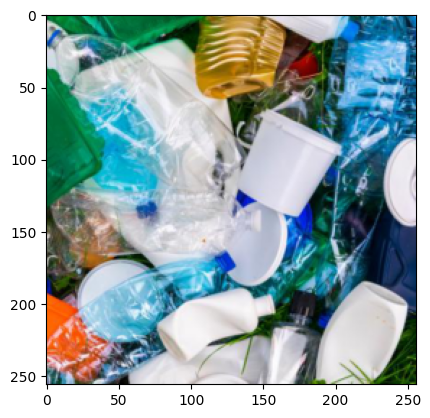

In [66]:
classify_image(image5)

Prediction for the image: metal.


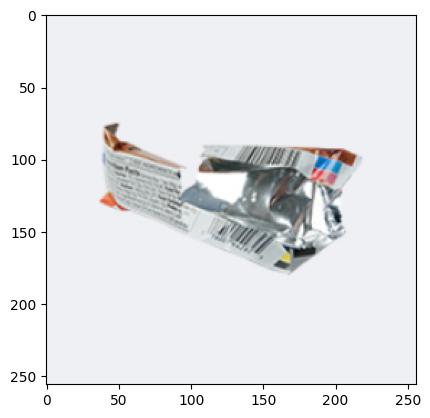

In [67]:
classify_image(image6)